# **Linear regression model diagnosis**

Tests for the principal assumptions [1][5][6]:

1. Linearity

2. Independence

3. Homoscedasticity
                         
4. Normality

OLS linear regression assumptions[4]:

1. Linearity(Y-X): The regression model is linear in the coefficients and the error term.

2. Multicollinearity(X-X): No independent variable is a perfect linear function of other explanatory variables

3. Errors uncorrelated (e_i-e_j): Observations of the error term has no autocorrelation in the order of being collected

4. Homoscedasticity(e): Errors have a constant variance (dentically distributed, + assumption 3 = IDD, spherical errors).

5. (e-X) Errors are uncorrelated with independent variables

6. Error mean = 0 (e)

7. Normality(e): optional 


In [ ]:
import pandas as pd
import numpy as np

from sklearn import linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [ ]:
cols=['GAMMA','DTCO']
#X = data[cols]
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [ ]:
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
X_train = X_train0[cols]
X_test = X_test0[cols]

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 2) (135562, 1)
(15063, 2) (15063, 1)


In [ ]:
scaler_x = preprocessing.StandardScaler().fit(X_train)
X_train_sc = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

## Linear regression with statsmodels



In [ ]:
model = sm.OLS(Y_train,sm.add_constant(X_train_sc))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                 4.459e+05
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:16:35   Log-Likelihood:            -5.3712e+05
No. Observations:              135562   AIC:                         1.074e+06
Df Residuals:                  135559   BIC:                         1.074e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.0317      0.035   3821.385      0.000     131.964     132.099
GAMMA         -3.0901      0.040    -76.414      0.000      -3.169      -3.011
DTCO          34.1251      0.040    843.855      0.000      34.046      34.204
==============================================================================
Omnibus:                     6027.266   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21080.990
Skew:                          -0.013   Prob(JB):                         0.00
Kurtosis:                       4.932   Cond. No.                         1.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##Multicollinearity





###Condition number test



In [ ]:
results.condition_number

1.7786557265117446

The condition number finds the ratio of the square root of the maximum eigenvalue to the minimum one of the design matrix. Statsmodels gives condition number with the standardized variables. 1.78 indicates that the linear model is well-conditioned here.

###Variance inflation factors (VIF): 



In [ ]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.values.shape[1])]
pd.DataFrame({'vif': vif[:]}, index=cols).T

,GAMMA,DTCO
vif,5.891872,5.891872


a VIF of 5 or 10 and above indicates a multicollinearity problem. A previous test (below) with more variables showed serious multicollinearity. VIF improves while only GAMMA and DTCO are used, as shown above.

|   | Depth | GAMMA | RHO | DTCO |
| --- | --- | --- | --- | --- |
| vif	| 6.700328 | 6.609758	| 28.853182	| 26.739058 |

## Linearity
### Plots

In [ ]:
obser = Y_train.DTSM
pred = results.fittedvalues
resid = results.resid
residsq = resid**2
resid_p = results.resid_pearson
dtco = X_train

_, preid_up, pred_lo = wls_prediction_std(results)

coef = results.params.values[1:,]
part_resid = resid + coef @ X_train_sc.values.T

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)


Residual mean: -2.0068500218927663e-15
Residual stdv: 12.721007962183664


In [ ]:
idx = np.random.choice(np.arange(len(pred)), 2000, replace=False)
resid_sample = resid.to_numpy()[idx]
resid_psample = resid_p[idx]
residsq_sample = residsq.to_numpy()[idx]
pred_sample = pred.to_numpy()[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, residsq_sort, resid_psort, obser_sort = zip(*sorted(zip(pred_sample, residsq_sample, resid_psample, obser_sample)))
resid_psm = lowess(resid_psort,pred_sort, frac=0.4)[:,1]
residsq_sm = lowess(residsq_sort,pred_sort, frac=0.4)[:,1]
obser_sm = lowess(obser_sort,pred_sort, frac=0.4)[:,1]

In [ ]:
def cm_wh(cmp_name):
  cmp = cm.get_cmap(cmp_name, 256)
  newcm = cmp(np.linspace(0, 1, 256))
  newcm[0, :] = np.array([1, 1, 1, 1])
  return ListedColormap(newcm)

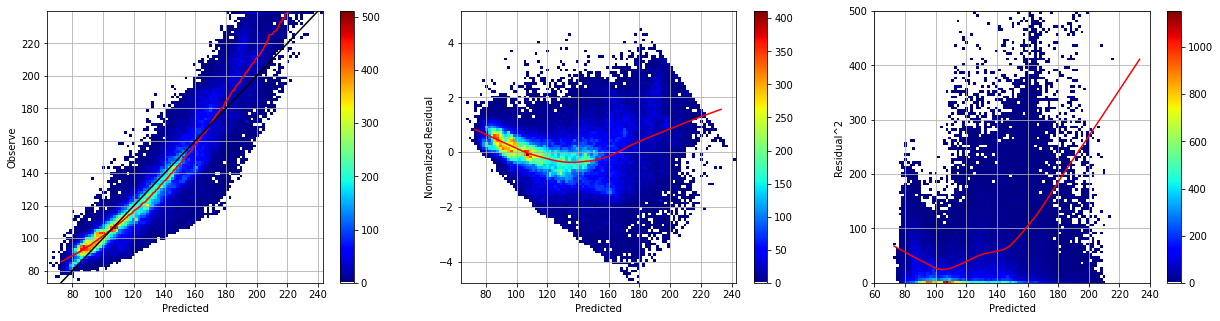

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,5))

h1=ax1.hist2d(pred, obser,bins=100, cmap=cm_wh('jet'))
ax1.plot(pred_sort, obser_sm, color='red')
x1 = np.linspace(*ax1.get_xlim())
ax1.plot(x1, x1, color='black')
#ax1.axline([0, 0], [1, 1], color='white')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observe")
ax1.grid()
fig.colorbar(h1[3], ax=ax1)

h2=ax2.hist2d(pred, resid_p,bins=100, cmap=cm_wh('jet'))
ax2.plot(pred_sort, resid_psm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Normalized Residual")
ax2.grid()
fig.colorbar(h2[3], ax=ax2)

h3=ax3.hist2d(pred, residsq, bins=100, range= [[60, 240], [0, 500]], cmap=cm_wh('jet'))
#ax3.scatter(pred, residsq,s=1)
ax3.plot(pred_sort, residsq_sm, color='red')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Residual^2")
ax3.set_ylim((0,500))
ax3.grid()
fig.colorbar(h3[3], ax=ax3)

plt.show()

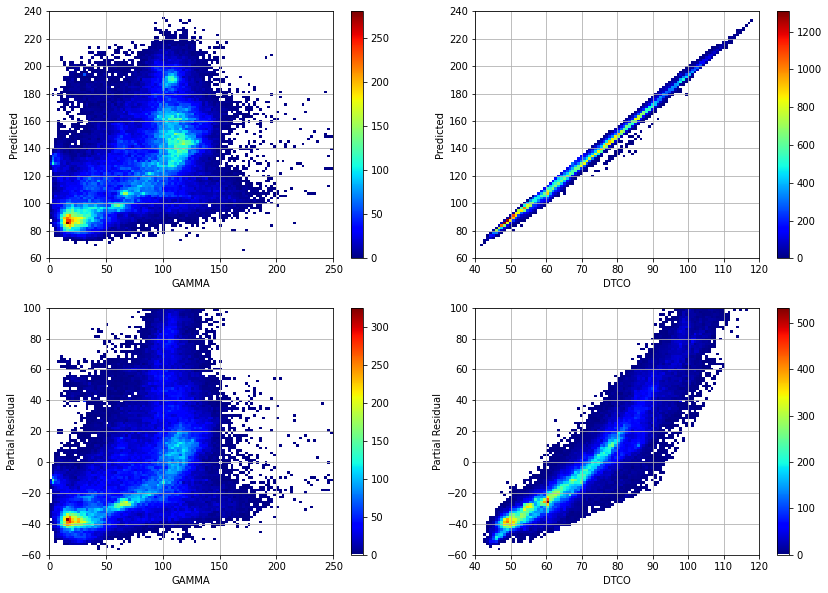

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

h00=ax[0,0].hist2d(X_train['GAMMA'], pred, bins=100, range= [[0, 250], [60, 240]], cmap=cm_wh('jet'))
#ax1.scatter(dtco, resid, s=1, color='blue')
ax[0,0].set_xlabel('GAMMA')
ax[0,0].set_ylabel("Predicted")
ax[0,0].set_xlim((0,250))
ax[0,0].grid()
fig.colorbar(h00[3], ax=ax[0,0])

h10=ax[1,0].hist2d(X_train['GAMMA'], part_resid,bins=100, range= [[0, 250], [-60, 100]], cmap=cm_wh('jet'))
ax[1,0].set_xlabel('GAMMA')
ax[1,0].set_ylabel("Partial Residual")
ax[1,0].set_xlim((0,250))
ax[1,0].grid()
fig.colorbar(h10[3], ax=ax[1,0])

h01=ax[0,1].hist2d(X_train['DTCO'], pred, bins=100, range= [[40, 120], [60, 240]], cmap=cm_wh('jet'))
#ax1.scatter(dtco, resid, s=1, color='blue')
ax[0,1].set_xlabel('DTCO')
ax[0,1].set_ylabel("Predicted")
ax[0,1].grid()
fig.colorbar(h01[3], ax=ax[0,1])

h11=ax[1,1].hist2d(X_train['DTCO'], part_resid,bins=100, range= [[40, 120], [-60, 100]], cmap=cm_wh('jet'))
ax[1,1].set_xlabel('DTCO')
ax[1,1].set_ylabel("Partial Residual")
ax[1,1].grid()
fig.colorbar(h11[3], ax=ax[1,1])

plt.show()

Residual plots also show a slight parabolic trend (red). This suggests residuals consist of random noise and nonlinear terms of the variables. Specification tests will be run to check on the possible nonlinear terms of the variables in the model.

### Harvey-Collier multiplier test:
linear specification

In [ ]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)


[('t value', 0.27125705412248624), ('p value', 0.7861937474281975)]

The Harvey-Collier test performs a t-test on the recursive residuals for the null hypothesis that the Y-X relationship is linear rather than convex or concave. The mean of the recursive residuals should be 0. The p-values of the Harvey-Collier multiplier test suggest that the null hypothesis is not rejected here. 

###Rainbow test

In [ ]:
name = ['F statistic', 'p-value']
test = sms.linear_rainbow(results,frac=0.5)
lzip(name, test)

[('F statistic', 1.0072407175999825), ('p-value', 0.17382900938898524)]

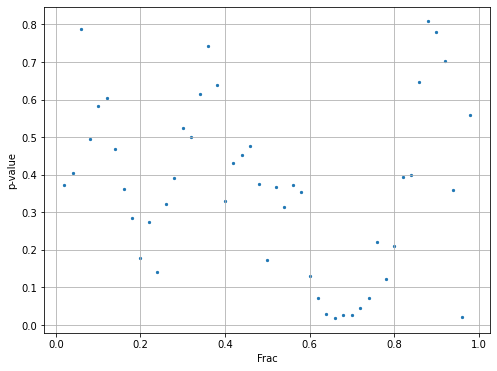

In [ ]:
rain_frac=[]
rain_pv=[]
for frac in np.arange(0.02,1,0.02):
  (_,pv)=sms.linear_rainbow(results, frac=frac)
  rain_frac.append(frac)
  rain_pv.append(pv)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.scatter(rain_frac, rain_pv, s=5)
ax.set_xlabel('Frac')
ax.set_ylabel("p-value")
ax.grid()

The rainbow test performs an F-test under the null hypothesis that the overall fit is the same as the fit for the subsample in the "middle" of the data. The test here gives linearity violation at some portion (frac ~ 0.7) of the data. This suggests some nonlinearity. 


##  Specification Tests

###White’s Two-Moment Specification Test: 
Regression of the residual, detecting any linear, quadratic interaction terms of the predictor variables.

In [ ]:
name = ['statistic', 'p-value','dof']
test = sms.diagnostic.spec_white(resid, model.exog)
lzip(name, test)

[('statistic', 12638.986675732009), ('p-value', 0.0), ('dof', 5)]

### Link Test:
Regress on the predicted and its squared to check on the significance of adding the quadratic terms of the variables.

In [ ]:
pred_st = (pred - np.mean(pred))/np.std(pred)
df_pred_sq = pd.concat([pred_st.to_frame('yhat'), (pred_st**2).to_frame('yhat_sq')], axis=1)

In [ ]:
link_test = sm.OLS(Y_train,sm.add_constant(df_pred_sq)).fit()
link_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 5.106e+05
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:16:48   Log-Likelihood:            -5.2907e+05
No. Observations:              135562   AIC:                         1.058e+06
Df Residuals:                  135559   BIC:                         1.058e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.1301      0.044   2901.059      0.000     128.044     128.217
yhat          31.1308      0.035    902.078      0.000      31.063      31.198
yhat_sq        3.9016      0.030    130.738      0.000       3.843       3.960
==============================================================================
Omnibus:                     9557.160   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45829.027
Skew:                          -0.154   Prob(JB):                         0.00
Kurtosis:                       5.832   Cond. No.                         2.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Ramsey RESET Test:
A more general form than link test, which includes power >= 2.

In [ ]:
#rest_test = sm.stats.diagnostic.linear_reset(resutls, power=2)
#reset_test.summary()

### Comments

All the above specification tests confirm that coef of the nonlinear/quadratic terms are significant. Therefore a quadratic term of DTCO will be added to a new polynomial regression model. 

##Homoskedasticity tests

###White’s Lagrange Multiplier Test
It tests if the variance of the errors in a regression model is constant.

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_white(results.resid, model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 19677.004147833868),
 ('p-value', 0.0),
 ('f-value', 4603.4190270265435),
 ('f p-value', 0.0)]

###Breush-Pagan test

It tests the hypothesis that the residual variance does not depend on the predictor variables. However, the nonlinear terms of the variables can also lead to a rejection of the null hypothesis.

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18998.74509498972),
 ('p-value', 0.0),
 ('f-value', 11047.438956772865),
 ('f p-value', 0.0)]

The null hypothesis of the White test and BP test are rejected, and heteroskedasticity assumed. It means that the residuals are linear or/and nonlinearly correlated to the variables. Nonlinear terms should be added to the new regression model so that only the random noise is left in the error term.


## Normality of the residuals

OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. 
However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.[6]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


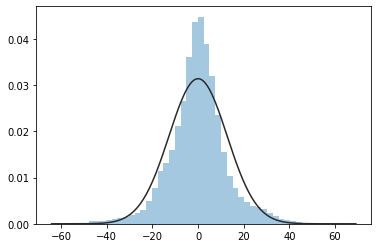

In [ ]:
sns.distplot(resid, kde=False, fit=norm)

###Jarque-Bera test:

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)


[('Jarque-Bera', 21080.99013904283),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', -0.012980727824043433),
 ('Kurtosis', 4.931714418654092)]

Skewness is slightly positive, and a Kurtosis > 3 indicates higher probabilities at the mean and the tails than a normal distribution, as the plot shows.

###Omni test:

In [ ]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 6027.265665538133), ('Two-tail probability', 0.0)]

Both tests reject the null hypothesis that the residual data are normally distributed.

QQ-plot:


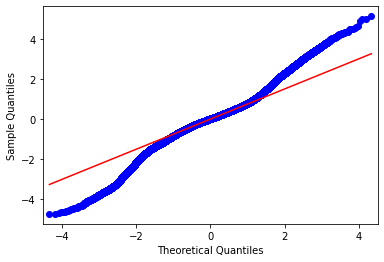

In [ ]:
fig = sm.qqplot(results.resid, fit=True, line='q')

plt.show()

The data have more extreme values than expected as normally distributed data. The following may be considered: (1)Using GLMs for non-Gaussian errors, 
(2)transforming target variables, (3)removing potential outliers.

##Outlier and Influence Diagnostic Measures
To be implemented

In [ ]:
#influence = OLSInfluence(results)


## Comments


Among the principal assumptions of linear regression, linearity, homoscedasticity, normality are violated.

OLS is also not BLUE since the residual variance is not constant.

Linearity is still held under some tests. However, the residual plots and the specification tests suggest nonlinearity in the residuals.

## Polynomial regression model

In [ ]:
X_train2 = X_train.copy()
X_train2['DTCO2'] = X_train2.DTCO**2
X_train2.head()

,GAMMA,DTCO,DTCO2
2381,69.2048,55.2948,3057.514907
141321,75.0239,89.1935,7955.480442
6245,19.3843,50.7166,2572.173516
92461,78.8619,66.2258,4385.856586
33364,135.3211,57.1439,3265.425307


In [ ]:
scaler_x2 = preprocessing.StandardScaler().fit(X_train2)
X_train2_sc = pd.DataFrame(scaler_x2.transform(X_train2), columns=X_train2.columns, index=X_train2.index)

In [ ]:
model2 = sm.OLS(Y_train,sm.add_constant(X_train2_sc))
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.469e+05
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        02:16:48   Log-Likelihood:            -5.2795e+05
No. Observations:              135562   AIC:                         1.056e+06
Df Residuals:                  135558   BIC:                         1.056e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.0317      0.032   4088.982      0.000     131.968     132.095
GAMMA         -1.3891      0.040    -34.995      0.000      -1.467      -1.311
DTCO          -8.6834      0.308    -28.220      0.000      -9.286      -8.080
DTCO2         42.1932      0.301    140.182      0.000      41.603      42.783
==============================================================================
Omnibus:                     9399.490   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45482.436
Skew:                          -0.133   Prob(JB):                         0.00
Kurtosis:                       5.825   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
obser = Y_train.DTSM
pred2 = res2.fittedvalues
resid2 = res2.resid
residsq2 = resid2**2
resid2_p = res2.resid_pearson
dtco = X_train2

coef2 = res2.params.values[1:,]
part_resid2 = resid2 + coef2 @ X_train2_sc.values.T

mean_res2 = np.mean(resid2)
stdv_res2 = np.std(resid2)

print("Residual mean:", mean_res2)
print("Residual stdv:", stdv_res2)

Residual mean: 2.7799443355918243e-14
Residual stdv: 11.888459693586528


In [ ]:
#idx = np.random.choice(np.arange(len(pred2)), 1000, replace=False)
resid2_sample = resid2.to_numpy()[idx]
resid2_psample = resid2_p[idx]
residsq2_sample = residsq2.to_numpy()[idx]
pred2_sample = pred2.to_numpy()[idx]
obser_sample = obser.to_numpy()[idx]

pred2_sort, residsq2_sort, resid2_psort, obser_sort = zip(*sorted(zip(pred2_sample, residsq2_sample, resid2_psample, obser_sample)))
resid2_psm = lowess(resid2_psort,pred2_sort,frac=0.4)[:,1]
residsq2_sm = lowess(residsq2_sort,pred2_sort,frac=0.4)[:,1]
obser_sm = lowess(obser_sort,pred2_sort, frac=0.4)[:,1]

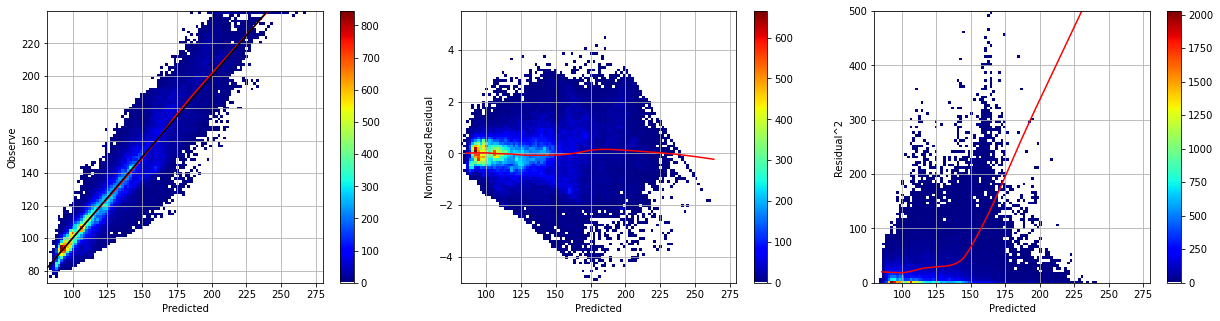

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,5))

h1=ax1.hist2d(pred2, obser,bins=100, cmap=cm_wh('jet'))
ax1.plot(pred2_sort, obser_sm, color='red')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observe")
ax1.grid()
fig.colorbar(h1[3], ax=ax1)
x1 = np.linspace(*ax1.get_xlim())
ax1.plot(x1, x1, color='black')

h2=ax2.hist2d(pred2, resid2_p,bins=100, cmap=cm_wh('jet'))
ax2.plot(pred2_sort, resid2_psm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Normalized Residual")
ax2.grid()
fig.colorbar(h2[3], ax=ax2)

h3=ax3.hist2d(pred2, residsq2, bins=100, range= [[80, 280], [0, 500]], cmap=cm_wh('jet'))
#ax3.scatter(pred, residsq,s=1)
ax3.plot(pred2_sort, residsq2_sm, color='red')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Residual^2")
ax3.set_ylim((0,500))
ax3.grid()
fig.colorbar(h3[3], ax=ax3)

plt.show()

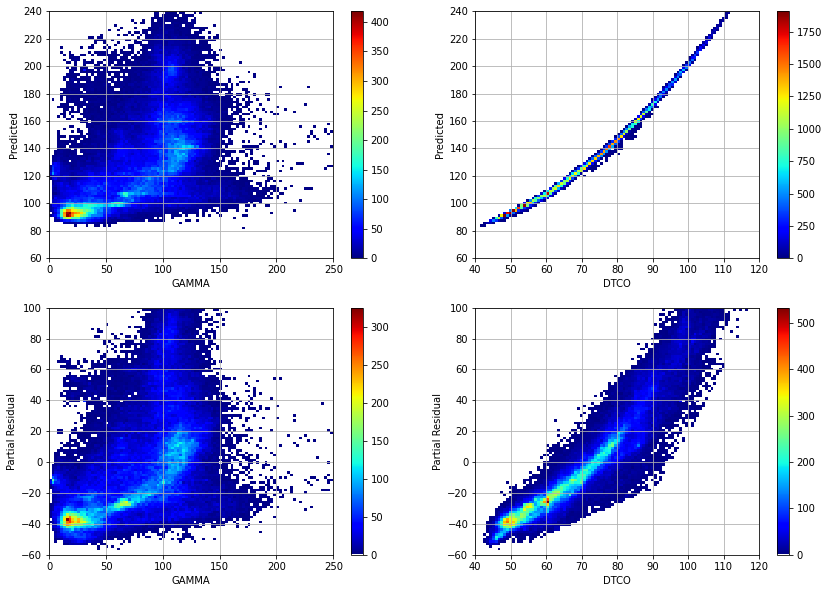

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

h00=ax[0,0].hist2d(X_train2['GAMMA'], pred2, bins=100, range= [[0, 250], [60, 240]], cmap=cm_wh('jet'))
#ax1.scatter(dtco, resid, s=1, color='blue')
ax[0,0].set_xlabel('GAMMA')
ax[0,0].set_ylabel("Predicted")
ax[0,0].set_xlim((0,250))
ax[0,0].grid()
fig.colorbar(h00[3], ax=ax[0,0])

h10=ax[1,0].hist2d(X_train2['GAMMA'], part_resid2,bins=100, range= [[0, 250], [-60, 100]], cmap=cm_wh('jet'))
ax[1,0].set_xlabel('GAMMA')
ax[1,0].set_ylabel("Partial Residual")
ax[1,0].set_xlim((0,250))
ax[1,0].grid()
fig.colorbar(h10[3], ax=ax[1,0])

h01=ax[0,1].hist2d(X_train2['DTCO'], pred2, bins=100, range= [[40, 120], [60, 240]], cmap=cm_wh('jet'))
#ax1.scatter(dtco, resid, s=1, color='blue')
ax[0,1].set_xlabel('DTCO')
ax[0,1].set_ylabel("Predicted")
ax[0,1].grid()
fig.colorbar(h01[3], ax=ax[0,1])

h11=ax[1,1].hist2d(X_train2['DTCO'], part_resid2, bins=100, range= [[40, 120], [-60, 100]], cmap=cm_wh('jet'))
ax[1,1].set_xlabel('DTCO')
ax[1,1].set_ylabel("Partial Residual")
ax[1,1].grid()
fig.colorbar(h11[3], ax=ax[1,1])

plt.show()

## Reference
[1] 
https://people.duke.edu/~rnau/testing.htm

[2]
https://www.statsmodels.org/stable/diagnostic.html

[3]
https://www.statsmodels.org/stable/_modules/statsmodels/stats/diagnostic.html


[4]
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

[5] https://github.com/rorytboyle/hierarchical_regression/blob/master/regression_diagnostics.py

[6] https://statisticsbyjim.com/regression/gauss-markov-theorem-ols-blue/


